In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, cv2, json, random, itertools, rasterio, math, time, psutil, warnings

# np.random.seed(0)
# tf.random.set_seed(0)

from tqdm import tqdm
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Concatenate)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from tensorflow.keras.preprocessing.image import img_to_array, load_img
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
warnings.filterwarnings("ignore")

2021-09-14 11:56:38.016257: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-14 11:56:38.016371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [4]:
def plot_learning_rate(loss_history):
    
    plt.style.use("ggplot")
    
    plt.plot(np.arange(0,len(loss_history.lr)), loss_history.lr)
    plt.show();
    pass

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar();
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False);
    pass

In [6]:
with open("../input/eurosat-dataset/EuroSATallBands/label_map.json","r") as f:
    class_names_encoded = json.load(f)
    pass

class_names = list(class_names_encoded.keys())
num_classes = len(class_names)
class_names_encoded

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [7]:
bands = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'8a':9,'9':10,'10':11,'11':12,'12':13}

In [8]:
def Normalise(arr_band):
    
    return StandardScaler().fit_transform(arr_band)

In [9]:
basePath = "../input/eurosat-dataset/EuroSATallBands"

def data_generator(csv_file, num_classes, batch_size = 10, target_size = 64):
    i = 0
    classes = set()
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples_idx = df.index[offset:offset+batch_size]

            X, y = [], []

            for i in batch_samples_idx:
                img_name = df.loc[i,'Filename']
                label = df.loc[i,'Label']

                src = rasterio.open(os.path.join(basePath,img_name))

                arr_3, arr_4, arr_8 = src.read(bands['3']).astype(np.float32), src.read(bands['4']).astype(np.float32), src.read(bands['8']).astype(np.float32)
                arr_6, arr_7 = src.read(bands['6']).astype(np.float32), src.read(bands['7']).astype(np.float32)
                arr_11 = src.read(bands['11']).astype(np.float32)

                arr_3 = Normalise(arr_3)
                arr_4 = Normalise(arr_4)
                arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
                arr_8 = Normalise(arr_8)
                arr_11 = Normalise(arr_11)

                bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

                X.append(bands_10_20)
                y.append(label)
                pass

            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes = num_classes)
            
            yield X, y
            pass
        pass
    pass

In [10]:
train_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/train.csv", num_classes = 10, batch_size = 10)
val_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/validation.csv", num_classes = 10, batch_size = 10)

In [11]:
train_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/train.csv")
train_labels = train_df.loc[:,'Label']
train_labels = np.array(train_labels)

num_train_samples = train_labels.shape[0]

val_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/validation.csv")
val_labels = val_df.loc[:,'Label']
val_labels = np.array(val_labels)

num_val_samples = val_labels.shape[0]

num_train_samples, num_val_samples

(19317, 5519)

In [12]:
def spectral_block(X,filters,stage,s=1):
    
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1,F2,F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3,3), strides=(s,s), padding='same', name=squeeze_base_name+'c')(X)
    
    X = Concatenate(name="concatenate_"+str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    
    X = Activation("relu", name="spectral"+str(stage))(X)
    
    return X
    pass

In [13]:
def SpectrumNet(input_shape, classes):
    
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1,1), strides=(2,2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16,96,32], 2)
    X = spectral_block(X, [16,96,32], 3)
    X = spectral_block(X, [32,192,64], 4)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32,192,64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64,384,128], 9)
    
    X = Conv2D(10, kernel_size=(1,1), strides=(1,1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8,8), strides=(1,1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    
#     X = Dense(16, name="dense_1")(X)
#     X = Activation("relu",name="dense_relu_1")(X)
    
#     X = Dense(256, name="dense_2")(X)
#     X = Activation("relu",name="dense_relu_2")(X)
    
#     X = Dense(512,name="dense_3")(X)
#     X = Activation("relu", name="dense_relu_3")(X)
    
#     X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model
    pass

In [14]:
model = SpectrumNet(input_shape = (64,64,6), classes=num_classes)

2021-09-14 11:57:22.012882: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 11:57:22.016023: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-14 11:57:22.016072: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-14 11:57:22.016099: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (98c13e3bb902): /proc/driver/nvidia/version does not exist
2021-09-14 11:57:22.016418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [15]:
model.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

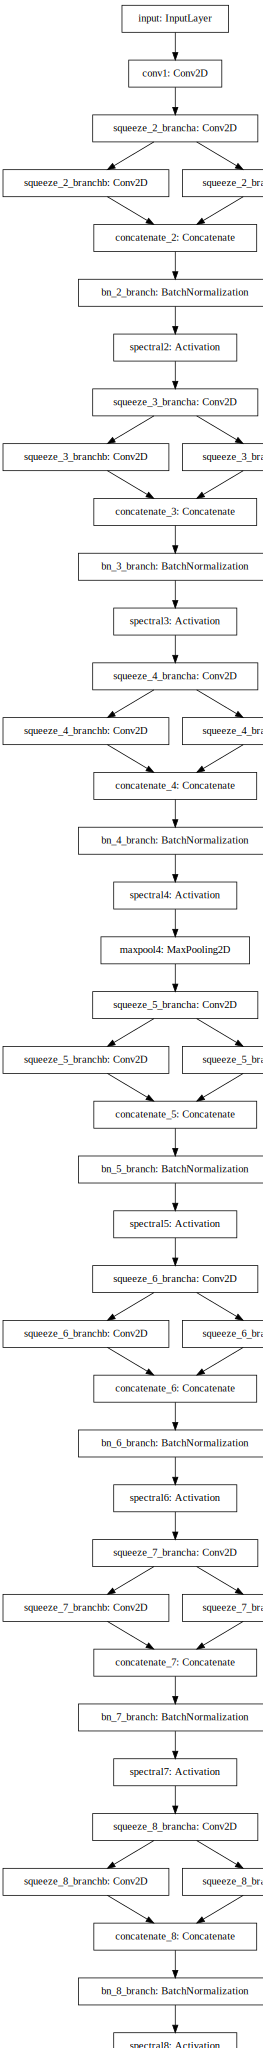

In [16]:
plot_model(model, to_file="6bands_v5-4.png",show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model).create(prog="dot", format='svg'))

In [17]:
checkpoint = ModelCheckpoint("6bands_weights_v5-5_SC.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard("6bands-logs-SC", histogram_freq=1)

2021-09-14 11:57:47.959884: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-14 11:57:47.959969: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-14 11:57:47.961794: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [18]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.10
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [19]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [20]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

In [21]:
train_labels_encoded = to_categorical(train_labels,num_classes=10)

classTotals = train_labels_encoded.sum(axis=0)
classWeight = {}

for i in range(len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight

{0: 1.1985714,
 1: 1.1985714,
 2: 1.1985714,
 3: 1.4382857,
 4: 1.4382857,
 5: 1.7978572,
 6: 1.4382857,
 7: 1.1985714,
 8: 1.4382857,
 9: 1.0}

In [22]:
# opt = Adam(lr=1e-3)
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
opt = SGD(lr=1e-3, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])